In [20]:
import bs4 as bs
import pandas as pd
import matplotlib as plt
from matplotlib import pyplot as pplt
import os 
import pprint as p

#Die Buch-Kürzel des alten Testaments
AT = ["Gn", "Ex", "Lv", "Nm", "Dt", "Ios", "Idc", "Rt", "1Sm", "2Sm", "3Rg", "4Rg", "1Par", "2Par", "Esr", "Neh", "Tb",
      "Idt", "Est", "1Mcc"
    , "2Mcc", "3Mcc", "4Mcc", "Iob", "Ps", "Prv", "Ecl", "Ct", "Sap", "Sir", "Is", "Ier", "Lam", "Bar", "Ez", "Dn",
      "Os", "Ioel", "Am", "Abd"
    , "Ion", "Mi", "Na", "Hab", "So", "Agg", "Za", "Mal"]


  
def percent_calc(num1, num2):
    return (num1/num2)*100
    


    

In der folgenden Zelle wird Suppe gemacht: 
Wir suchen alle refs, die das Attribut 'cref' haben, sowie alle note, die ein ref mit cref haben. 

In [2]:
#old version
with open(f'interim.xml', 'r') as f:
    file = f.read()   
soup = bs.BeautifulSoup(file, 'lxml')
Refs = soup.select('ref[cRef]')

data = []
for ref in Refs:
    if ref.get('cref').split('_')[0] in AT:
        data.append((ref.get('cref') , 'at', ref.getText() , ref.parent.find_previous_sibling('q')))
    else:
        data.append((ref.get('cref') , 'nt', ref.getText() , ref.parent.find_previous_sibling('q')))

    #die nun gefüllte Liste wird zum pd.DataFrame (df_data) konvertiert und die Spaltenbezeichnungen angepasst
df_data = pd.DataFrame(data)
df_data.columns = ['kuerzel', 'atnt', 'stelle', 'zitat']

qs = []
for ref in Refs:
    if ref.parent.find_previous_sibling() == ref.parent.find_previous_sibling("q"):
        qs.append(ref.parent.find_previous_sibling("q"))

        


stellen = []
for i in range (0, len(df_data)):
    if df_data['zitat'][i] is not None:
        stellen.append(df_data['stelle'][i])
        

        
quote_len=0
for i in range(len(df_data)):
    if (df_data['zitat'][i] != 'not a direct quote'):
        quote_len +=len(str(df_data['zitat'][i]).replace(" ", ""))
    i+=1
    
print(quote_len)
test = bs.BeautifulSoup(file, 'lxml')

test_soup = test.select('div')
total_len=0
for i in range(len(test_soup)):
    total_len += len(test_soup[i].getText().replace(" ", ""))
print(f"Anzahl an erfassten Bibelstellen: {len(Refs)}")
print("Gesamtlänge:" + str(total_len))
print("Zitatlänge :"+str(quote_len))    
print("Prozentualer Anteil: " +(str(percent_calc(quote_len, total_len))))
print("Davon wörtl. zitiert:" + str(len(qs)))

        

31410
Anzahl an erfassten Bibelstellen: 283
Gesamtlänge:225274
Zitatlänge :31410
Prozentualer Anteil: 13.943020499480632
Davon wörtl. zitiert:114


AxesSubplot(0.125,0.11;0.775x0.77)


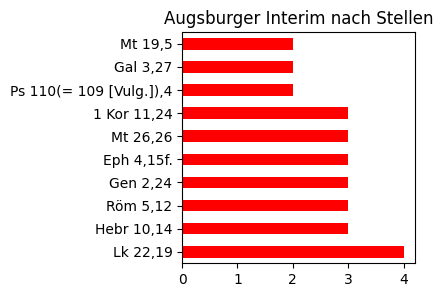

In [3]:
print(df_data["stelle"].value_counts()[:10].plot(figsize=(3,3), kind="barh", legend=False, title="Augsburger Interim nach Stellen", color="red"))


AxesSubplot(0.1275,0.11;0.77x0.77)


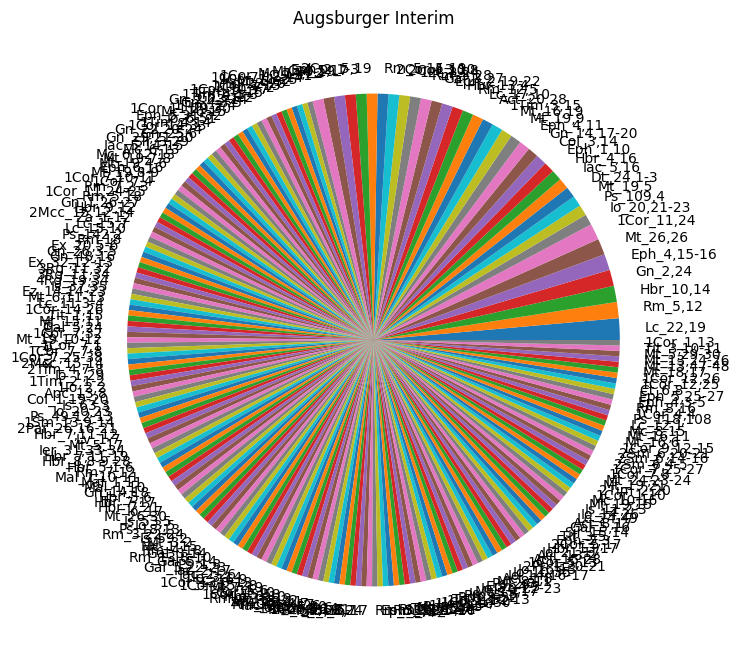

In [4]:
print(df_data["kuerzel"].value_counts().plot(figsize=(8,8), kind="pie", legend=False, title="Augsburger Interim"))

AxesSubplot(0.1275,0.11;0.77x0.77)


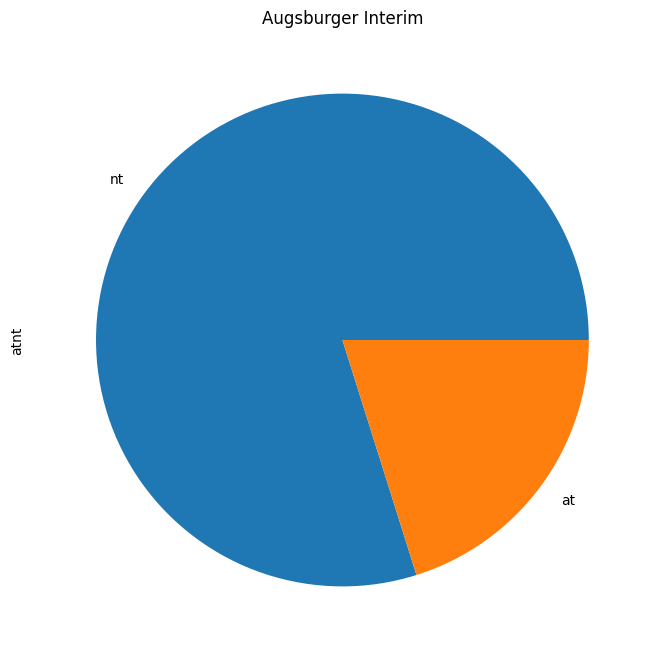

In [5]:
print(df_data["atnt"].value_counts().plot(figsize=(8,8), kind="pie", legend=False, title="Augsburger Interim"))

In [6]:
df_data.groupby("atnt").count()

,kuerzel,stelle,zitat
atnt,,,
at,57,57,34
nt,226,226,116


Einzelne Kapitel folgen hier

Die Visualisierungen und Aussagen für einzelne Kapitel:

AxesSubplot(0.1275,0.11;0.77x0.77)


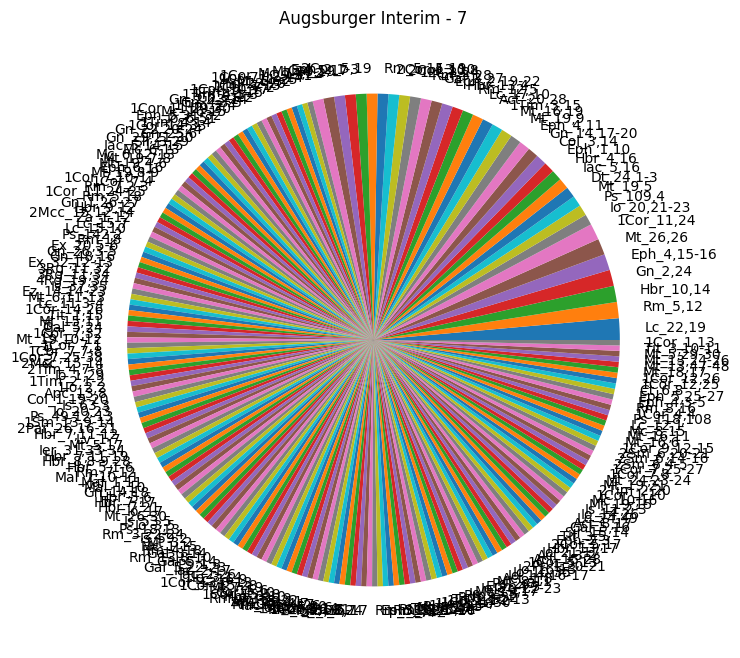

In [7]:
print(df_data["kuerzel"].value_counts().plot(figsize=(8,8), kind="pie", legend=False, title="Augsburger Interim - 7"))

Kapitel 2:

In [8]:
for i in range (0, len(df_data)):
    if df_data['zitat'][i] is not None:
        print(df_data['stelle'][i])

Sir 15,14
Röm 5,12
2 Kor 5,19
Ps 51,12
1 Kor 6,11
Tit 3,5-7
Röm 7,25
1 Joh 1,8
10
1 Kor 1,30
1 Joh 2,1f.
Tit 2,12f.
Mt 3,2
Mk 1,15
1 Kor 15,58
Hebr 6,10
Sir 18,22 (Vulg.)
Offb 22,11
Jo 15,3
Jak 2,14-26
Mt 19,17
Mt 19,21
1 Kor 7,8
25-27
2 Sam 4f.
14-16
20f.
1 Kor 9,12-15
Ps 119(= 118 [Vulg.]),108
Röm 12,5
Eph 25,25-27
Eph 4,15f.
1 Kor 12,25
1 Kor 12,26
Mt 18,17
Apg 20,28
Eph 4,11
Tit 3,10f.
2 Tim 2,20
1 Kor 1,10
Ps 2,8
Mt 8,11
Apg 1,8
Joh 14,16f.
2 Petr 1,20f.
1 Kor 5,13
Apg 15,28
2 Kor 10,8
13,10
Eph 4,11
Apg 13,2
Joh 21,17
2 Kor 10,8
13,10
Hebr 13,17
Tit 3,5
Joh 3,5
Mt 28,19
Gal 5,16
Lk 24,49
Joh 14,26
Joh 20,22f.
Hebr 4,16
Joh 20,21-23
Ps 18,13 (Vulg.)
Joh 20,23
1 Kor 10,17
Mt 26,26
Mk 14,22
Lk 22,19
1 Kor 11,24
Lk 22,20
1 Kor 11,25
1 Kor 11,29f.
Mk 6,13
Jak 5,14f.
1 Kor 14,33
1 Tim 4,14
Joh 20,21-23
Mk 16,15
Mt 28,19
Lk 22,19
1 Kor 11,24f.
Mt 19,5
Gen 2,24
Mt 19,4-6
Mt 19,8f.
1 Kor 7,10f.
Gen 2,24
Mt 19,5
1 Kor 7,4
Röm 7,2f.
Mt 19,9
1 Kor 7,2
1 Kor 7,12-14
Gen 2,24
1 Tim 2,15
Hebr 1

In [9]:

for i in range (0, len(df_data)):
    if df_data['zitat'][i] is not None:
        print(df_data['zitat'][i].getText())

hat in Gott gelassen inn der hand seines eig-
nen Raths
die sünde ist durch eynen
               
Roma. 5.menschen inn die welt kommen unnd durch die sünde der
               tod
was warhafftig inn
               Christo und versönet die welt mit im selber und rechnete
               inen ire sündenMehlhausen, Augsburger Interim, S. 42: sünde. nicht zu unnd hat under uns auffgericht
               das wort von der versunung.
Herr, schaff inn mir
               
1. Cor. 6.eyn reyn hertz und verneu inn meinen innwendigen dei-
nen richtigen Geyst.
Eygentlich seyt ir abgewaschen, Ir seit geheyliget, Ir
               seit gerechtfertiget.
nit umb der werck willen der gerechtigkeyt,
               
Titum 3.die wir gethon hetten, Sonder nach seiner barmhertzig-
keyt durch das bad der Widergeburt und verneuerung
               des Heyligen Geysts, welchen er reichlich außgegossen
               hat auff uns durch Jesum Christum, unsern Heylandt,
               auff das wir, durch sein gnad ge

# Öffnen und Vorbereitung

An dieser Stelle wird die integrierte Methode open() zum öffnen der XML-Datei genutzt. 
BeautifulSoup bereitet die Daten für das Scrapen vor.

In [10]:
with open(f'interim2.xml', 'r') as f:
    file = f.read()   
soup = bs.BeautifulSoup(file, 'lxml')
Refs = soup.select('ref[cRef]')


In [11]:
# Eine leere Liste wird erstellt und mit den Bibelstellen gefüllt. Hierbei wird sortiert, ob sie im Alten Testament stehen oder nicht. 
# Ein zweites Auswahlkriterium ist die Frage, ob direkt vor dem Eltern-ELement des <ref type='biblical'> ein <q> steht, und somit ein direktes Zitat vorliegt.
data = []
for ref in Refs:
    if ref.get('cref').split('_')[0] in AT:
        for ref in Refs:
            if ref.parent.previous_sibling == ref.parent.find_previous_sibling("q"):
                data.append((ref.get('cref') , 'at', ref.getText() , ref.parent.find_previous_sibling('q').get_text(' ',strip=True) if ref.parent.find_previous_sibling() == ref.parent.find_previous_sibling('q') else 'not a direct quote'))
    else:
        for ref in Refs:
            if ref.parent.previous_sibling == ref.parent.find_previous_sibling("q"):
                data.append((ref.get('cref') , 'nt', ref.getText() , ref.parent.find_previous_sibling('q').get_text(' ',strip=True) if ref.parent.find_previous_sibling() == ref.parent.find_previous_sibling('q') else 'not a direct quote'))

Diese Liste enthält nun also die Einträge nach folgendem Muster:<br>
**('Sir_15,14', 'at', 'Sir 15,14', 'hat in Gott gelassen inn der hand seines eig - nen Raths')**<br>
im nächsten Schritt wird sie in einen Dataframe konvertiert und der Header entsprechend gesetzt.

In [12]:
# der eigentliche Dataframe wird gesetzt
df_data = pd.DataFrame(data)
# der Header wird gesetzt.
df_data.columns = ['kuerzel', 'atnt', 'stelle', 'zitat']



stellen = []
for i in range (0, len(df_data)):
    if df_data['zitat'][i] != 'not a direct quote':
        stellen.append(df_data['stelle'][i])


# Hier wird eine Liste der wörtlichen Zitate erstellt
qs = []
for ref in Refs:
    if ref.parent.find_previous_sibling() == ref.parent.find_previous_sibling("q"):
        qs.append(ref.parent.find_previous_sibling("q").get_text(" ", strip=True))


# Zählen der Gesamtlänge des zitierten Textes; one Leerzeilen und Zeilenumbrüche 
quote_len = 0
for i in range(len(qs)):
    quote_len +=len(qs[i].replace(" ","").replace("\n", ""))
    i+=1



ges = bs.BeautifulSoup(file, 'lxml')

ges_soup = ges.select('div')
total_len=0
for i in range(len(ges_soup)):
    total_len += len(ges_soup[i].getText().replace(" ", "").replace("n", ""))
print(f"Anzahl an erfassten Bibelstellen: {len(Refs)}")
print(f"wörtliche Zitate: {len(qs)}")
print("Gesamtlänge:" + str(total_len))
print("Zitatlänge :"+str(quote_len))    
print("Prozentualer Anteil: " +(str(percent_calc(quote_len, total_len))))


Anzahl an erfassten Bibelstellen: 283
wörtliche Zitate: 114
Gesamtlänge:204612
Zitatlänge :9713
Prozentualer Anteil: 4.747033409575196


# Auswertungen

Alle vorkommenden Stellen in einem Tortendiagram. 

AxesSubplot(0.1275,0.11;0.77x0.77)


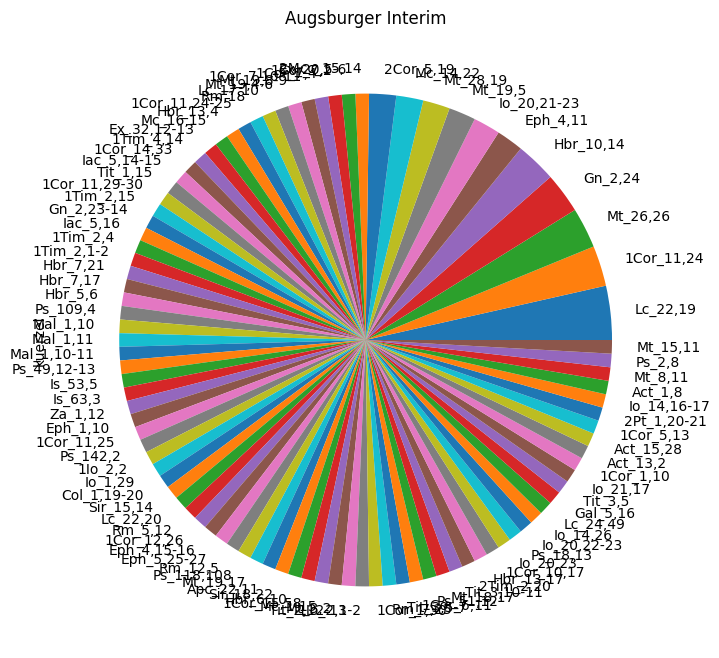

In [13]:
print(df_data["kuerzel"].value_counts().plot(figsize=(8,8), kind="pie", legend=False, title="Augsburger Interim"))

Visualisierung nach Zugehörigkeit zum Alten Testament.

AxesSubplot(0.1275,0.11;0.77x0.77)


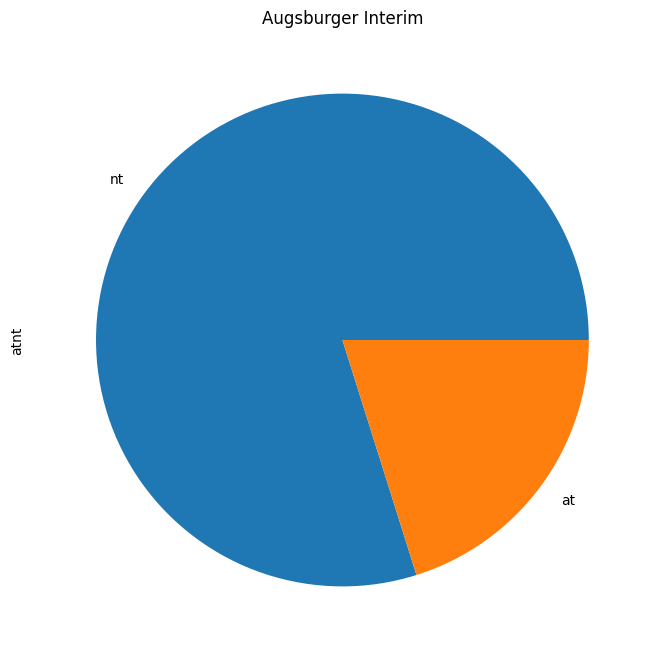

In [14]:
print(df_data["atnt"].value_counts().plot(figsize=(8,8), kind="pie", legend=False, title="Augsburger Interim"))

31979
AxesSubplot(0.125,0.11;0.775x0.77)


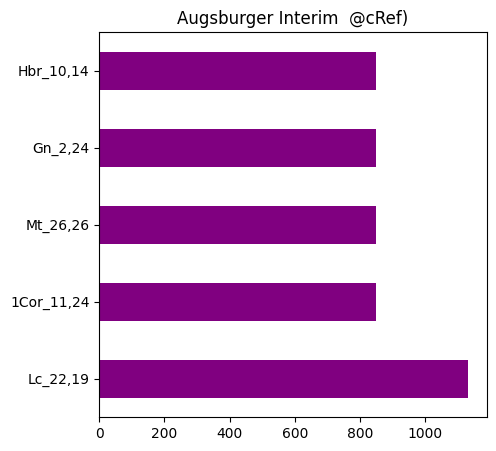

In [15]:
print(len(df_data))
print(df_data["kuerzel"].value_counts()[:5].plot(figsize=(5,5), kind="barh", legend=False, title="Augsburger Interim  @cRef)", color="purple"))

AxesSubplot(0.125,0.11;0.775x0.77)


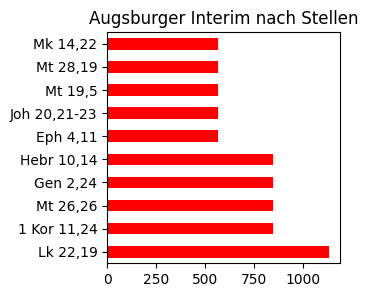

In [16]:
print(df_data["stelle"].value_counts()[:10].plot(figsize=(3,3), kind="barh", legend=False, title="Augsburger Interim nach Stellen", color="red"))

# Für einzelne Kapitel

In [22]:
data =[]
with open(f'interim_26/ch_07.xml', 'r') as f:
    file = f.read()   
soup = bs.BeautifulSoup(file, 'lxml')
Refs = soup.select('ref[cRef]')

data = []
for ref in Refs:
    if ref.get('cref').split('_')[0] in AT:
        for ref in Refs:
            if ref.parent.previous_sibling == ref.parent.find_previous_sibling("q"):
                data.append((ref.get('cref') , 'at', ref.getText() , ref.parent.find_previous_sibling('q').get_text(' ',strip=True) if ref.parent.find_previous_sibling() == ref.parent.find_previous_sibling('q') else 'not a direct quote'))
    else:
        for ref in Refs:
            if ref.parent.previous_sibling == ref.parent.find_previous_sibling("q"):
                data.append((ref.get('cref') , 'nt', ref.getText() , ref.parent.find_previous_sibling('q').get_text(' ',strip=True) if ref.parent.find_previous_sibling() == ref.parent.find_previous_sibling('q') else 'not a direct quote'))


# der eigentliche Dataframe wird gesetzt
df_data = pd.DataFrame(data)
# der Header wird gesetzt.
df_data.columns = ['kuerzel', 'atnt', 'stelle', 'zitat']



stellen = []
for i in range (0, len(df_data)):
    if df_data['zitat'][i] != 'not a direct quote':
        stellen.append(df_data['stelle'][i])


# Hier wird eine Liste der wörtlichen Zitate erstellt
qs = []
for ref in Refs:
    if ref.parent.find_previous_sibling() == ref.parent.find_previous_sibling("q"):
        qs.append(ref.parent.find_previous_sibling("q").get_text(" ", strip=True))


# Zählen der Gesamtlänge des zitierten Textes; one Leerzeilen und Zeilenumbrüche 
quote_len = 0
for i in range(len(qs)):
    quote_len +=len(qs[i].replace(" ","").replace("\n", ""))
    i+=1



ges = bs.BeautifulSoup(file, 'lxml')

ges_soup = ges.select('div')
total_len=0
for i in range(len(ges_soup)):
    total_len += len(ges_soup[i].getText().replace(" ", "").replace("n", ""))
print(f"Anzahl an erfassten Bibelstellen: {len(Refs)}")
print(f"wörtliche Zitate: {len(qs)}")
print("Gesamtlänge:" + str(total_len))
print("Zitatlänge :"+str(quote_len))    
print("Prozentualer Anteil: " +(str(percent_calc(quote_len, total_len))))

Anzahl an erfassten Bibelstellen: 34
wörtliche Zitate: 6
Gesamtlänge:4075
Zitatlänge :312
Prozentualer Anteil: 7.656441717791411
